## Overview

This project is about classifcation of COVID-19 affected patients based in CT-Lungs Scan Data.

In [3]:
import os
import sys

DATA_PATH = '.'

assert os.path.isdir(DATA_PATH)
COVID_PATH=DATA_PATH+'/COVID_CASES'
NON_COVID_PATH=DATA_PATH+'/NON_COVID_CASES'


Error: Jupyter cannot be started. Error attempting to locate jupyter: Select an Interpreter to start Jupyter

In [4]:
!ls {DATA_PATH}

COVID_CASES		covidct.zip  CT_NonCOVID  NON_COVID_CASES
COVID-CT-MetaInfo.xlsx	CT_COVID     drive	  sample_data


## Data Metrics

In [5]:
def total_cases():
  covid_cases=len(os.listdir(COVID_PATH+'/CT_COVID/'))
  non_covid_cases=len(os.listdir(NON_COVID_PATH+'/CT_NonCOVID/'))
  print("Total No. of Covid Cases:", covid_cases)
  print("Total No. of Non-Covid Cases:", non_covid_cases)
total_cases()

Total No. of Covid Cases: 349
Total No. of Non-Covid Cases: 397


# Import Libs and set seed

In [6]:
import random
import numpy as np
import torch
import torch.nn as nn


# set seed
seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

## Load COVID-19 Data and Define image transformations


In [7]:
from torch.utils.data.dataset import random_split

from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

covid_images = ImageFolder(root=COVID_PATH)
non_covid_images = ImageFolder(root=NON_COVID_PATH)
#print(type(non_covid_dataset[0]))

total_images=len(covid_images) + len(non_covid_images)
dataset=[]
for idx, img in enumerate(covid_images):
  dataset.append((img[0], 1))

for idx, img in enumerate(non_covid_images):
  #dataset[len(covid_images)+idx]=img
  dataset.append((img[0], 0))

import random
random.shuffle(dataset)
#dataset

In [8]:
#transformers of  images
import torchvision.transforms as transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

## Create Custom Datase to collate both covid and non-covid images

In [9]:
#Build Custom DataSet, add traget and img and add transformation in __get_item
from torch.utils.data import Dataset
from PIL import Image
class CovidDataset(Dataset):
    
    def __init__(self, dataset,  transform):
        self.dataset = []
        self.y=[]
        for img in dataset:
          self.dataset.append(img[0])
          self.y.append(img[1])
        self.transform=transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        image = self.dataset[index].convert('RGB')
        if self.transform:
            image = self.transform(self.dataset[index])
        return (image, self.y[index])

## Create Training, Validation and Test datasets


In [10]:
#Split dataset
def split_dataset(dataset, split_percent):
    split = int(len(dataset)*split_percent)
    lengths = [split, len(dataset) - split]
    train_dataset, test_dataset = random_split(dataset, lengths)
    return train_dataset, test_dataset

train_dataset, test_dataset =split_dataset(dataset,0.9)
train_dataset, val_dataset =split_dataset(train_dataset,0.8)



print("Train Dataset size:", len(train_dataset))
print("Validation Dataset size:", len(val_dataset))
print("Test Dataset size:", len(test_dataset))


Train Dataset size: 536
Validation Dataset size: 135
Test Dataset size: 75


In [11]:
covid_train_dataset=CovidDataset(train_dataset, train_transformer)
covid_val_dataset=CovidDataset(val_dataset, val_transformer)
covid_test_dataset=CovidDataset(test_dataset, val_transformer)

#print(len(covid_train_dataset))
#for idx, img  in enumerate(covid_train_dataset):
#  print(img[0].shape, img[1])



## Init DataLoaders and Visulaize images

Train DataSet: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


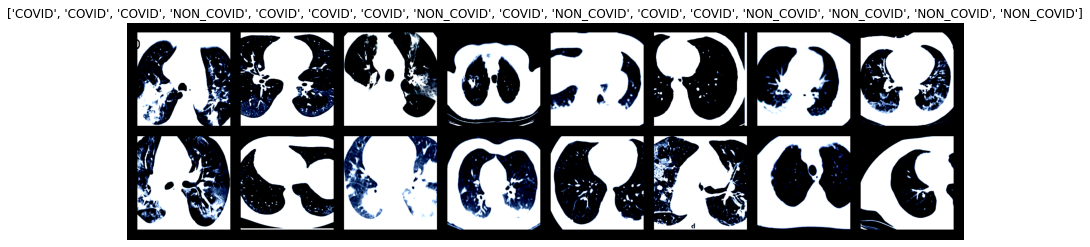

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Validation Dataset: 


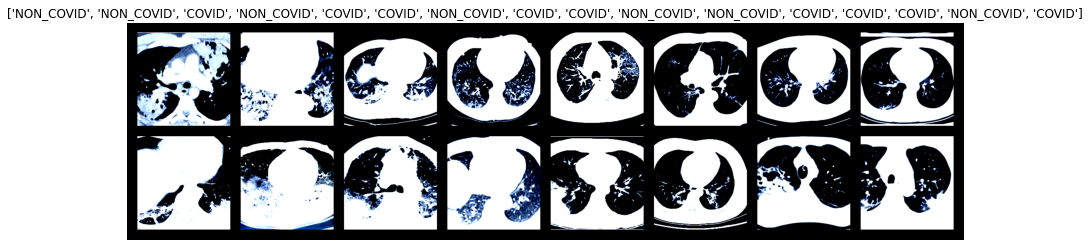

In [12]:
from  torchvision.utils import make_grid
import matplotlib.pyplot as plt
batch_size=16

#######============  Info on dataLoaders ================#########
#train loader will contain samples of shape len/batchsize and and 
#each sample will have num of image data =  batch size and image data will 
#contain image of shape 3x224x224 and "1/0=covid/noncovid"


train_loader = DataLoader(dataset=covid_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=covid_val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=covid_test_dataset, batch_size=batch_size, shuffle=True)

def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))

    img = make_grid(images, padding=25)

    imshow(img, title=["COVID" if label==1  else "NON_COVID" for label in labels ])

print("=="*10)
print('\033[1m'+"Train DataSet: ")  
show_batch_images(train_loader)
print("=="*50)
print('\033[1m'+"Validation Dataset: ")
show_batch_images(val_loader)


## Criterion and Optimizer

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = None
optimizer = None

model=None
criterion = nn.CrossEntropyLoss()
if model:
  optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [14]:
!pip install torchvision
!pip install --upgrade certifi

Requirement already up-to-date: certifi in /usr/local/lib/python3.7/dist-packages (2020.12.5)


## Model Implementation DenseNet169

In [15]:
import torch.nn.functional as F
import torchvision, torch
import math
import torch.optim as optim
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

densenet169 = torch.hub.load('pytorch/vision:v0.9.0', 'densenet169', pretrained=True)

# print(pretrained)
class MyDenseNet169(nn.Module):
    def __init__(self, my_pretrained_model):
        super(MyDenseNet169, self).__init__()
        self.pretrained = my_pretrained_model
        self.my_new_layers = nn.Sequential(nn.ReLU(), 
                                           nn.Linear(1000, 100),
                                           nn.ReLU(),
                                           nn.Linear(100, 2))
        
        
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.my_new_layers(x)
        return x

densenet169_extended = MyDenseNet169(my_pretrained_model=densenet169)

for param in densenet169_extended.named_parameters():
    if param[0].startswith('pretrained.classifier') or param[0].startswith('my_new_layers'):
        continue      
    param[1].requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(densenet169_extended.parameters(), lr=0.005)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


## Model Training DenseNet169

In [16]:
from sklearn.metrics import *

denseNetEpochs=[]
denseNetAccuracy=[]
denseNetLoss=[]

def eval_model(model, test_dataloader):
    model.eval()
    y_pred = torch.LongTensor()
    y_true = torch.LongTensor()
    for data, target in test_dataloader:  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        target = target.to(device)

        out = model(data)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        y_pred = torch.cat((y_pred,  pred.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, target.detach().to('cpu')), dim=0)
    return y_pred, y_true

def train_model(model, train_dataloader, n_epoch=10, optimizer=optimizer, criterion=criterion, batch_size=batch_size, plot=False):
#     import torch.optim as optim

    model.train() 
    batch_size =batch_size 
    losses = []
    accuracies =[]
    running_corrects = 0
    for epoch in range(n_epoch):
        denseNetEpochs.append(epoch)
        curr_epoch_loss = []
        for data, target in train_dataloader:
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            model_out = model(data)
            loss = criterion(model_out,target)
            loss.backward()
            optimizer.step()
            losses.append(float(loss)/batch_size)
            curr_epoch_loss.append(loss.cpu().data.numpy())
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
        y_pred, y_true = eval_model(densenet169_extended, train_dataloader)
        val_roc_auc = roc_auc_score(y_true, y_pred)
        denseNetAccuracy.append(val_roc_auc)
        print(f"Epoch {epoch} " +str(val_roc_auc))
        denseNetLoss.append(np.mean(curr_epoch_loss))
    print(denseNetAccuracy)
    print(denseNetLoss)
    if plot:
        plt.figure()
        plt.plot(range(len(losses)), losses)
        plt.show() 
    return model











In [17]:
import time

densenet169_extended.to(device)

n_epochs = 30
start_time = time.time()
densenet169_extended = train_model(densenet169_extended, train_loader, n_epoch=n_epochs)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0: curr_epoch_loss=0.6539739966392517
Epoch 0 0.6426894701542589
Epoch 1: curr_epoch_loss=0.5951024293899536
Epoch 1 0.7005365526492288
Epoch 2: curr_epoch_loss=0.5649581551551819
Epoch 2 0.7299910574558461
Epoch 3: curr_epoch_loss=0.5349704027175903
Epoch 3 0.7347417840375587
Epoch 4: curr_epoch_loss=0.5208070874214172
Epoch 4 0.7746758327744242
Epoch 5: curr_epoch_loss=0.5023854970932007
Epoch 5 0.7551699083389224
Epoch 6: curr_epoch_loss=0.47172069549560547
Epoch 6 0.7147607869438856
Epoch 7: curr_epoch_loss=0.4537181854248047
Epoch 7 0.780320813771518
Epoch 8: curr_epoch_loss=0.47055894136428833
Epoch 8 0.823775989268947
Epoch 9: curr_epoch_loss=0.4666794240474701
Epoch 9 0.8117594455622625
Epoch 10: curr_epoch_loss=0.42908206582069397
Epoch 10 0.8345070422535211
Epoch 11: curr_epoch_loss=0.4133121371269226
Epoch 11 0.8348423876592891
Epoch 12: curr_epoch_loss=0.40478265285491943
Epoch 12 0.8189414263357926
Epoch 13: curr_epoch_loss=0.39454296231269836
Epoch 13 0.833836351441

## Model Implementation Chexnet

In [18]:
# Base Chexnet implementation
class DenseNet121(nn.Module):
    """Model modified.

    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.

    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

# modify for single use
class CovidChexNet(nn.Module):
    def __init__(self, chexnet):
        super(CovidChexNet, self).__init__()
        self.pretrained = chexnet
        self.newlayers = nn.Sequential(nn.ReLU(), 
                                       nn.Linear(14, 2))        
        
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.newlayers(x)
        return x


In [19]:
import re

# load pretrained states
checkpoint = torch.load("./Model1/chexnet.pth.tar",map_location= device)
state_dict = checkpoint['state_dict']
remove_data_parallel = True # Change if you don't want to use nn.DataParallel(model)

pattern = re.compile(
    r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

for key in list(state_dict.keys()):
    match = pattern.match(key)
    new_key = match.group(1) + match.group(2) if match else key
    new_key = new_key[7:] if remove_data_parallel else new_key
    state_dict[new_key] = state_dict[key]
    # Delete old key only if modified.
    if match or remove_data_parallel: 
        del state_dict[key]

# load state checkpoint
model_ft = DenseNet121(14)
model_ft.load_state_dict(state_dict)


chexnet_model = CovidChexNet(model_ft)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


## Model Implementation ResNet

In [20]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import  torchvision.models as models
resnet_model = models.resnet50(pretrained=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


## Model Training


In [21]:
# trains then validates every opoch
import time
import copy


def train_and_validate(model, dataloaders, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    dataset_sizes = {
        "train": len(dataloaders["train"].dataset),
        "val": len(dataloaders["val"].dataset),
    }

    stats = {
        "train":{
            "loss": [],
            "acc": []
        },
        "val":{
            "loss": [],
            "acc": []
        }
    }


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                #pass
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            stats[phase]["loss"].append(epoch_loss)
            stats[phase]["acc"].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            #print('running_los:', running_loss, dataset_sizes[phase])
            #print('running_corrects:', running_corrects, dataset_sizes[phase])

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, stats

In [22]:
combined_loader = {
    "train": train_loader,
    "val": val_loader
}

## Model Training Chexnet

In [23]:
# define prameters
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(chexnet_model.parameters(), lr=0.005, momentum=0.9)

# Scheduler if needed
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [24]:
combined_loader = {
    "train": train_loader,
    "val": val_loader
}

chexnet_model.to(device)

chexnet_model, chexnet_stats = train_and_validate(chexnet_model, combined_loader, criterion, optimizer, exp_lr_scheduler, num_epochs=50)


Epoch 0/49
----------
train Loss: 0.6914 Acc: 0.5392
val Loss: 0.6819 Acc: 0.5852
Epoch 1/49
----------
train Loss: 0.6741 Acc: 0.5877
val Loss: 0.6580 Acc: 0.6741
Epoch 2/49
----------
train Loss: 0.6517 Acc: 0.6325
val Loss: 0.6278 Acc: 0.7037
Epoch 3/49
----------
train Loss: 0.6040 Acc: 0.7127
val Loss: 0.5964 Acc: 0.6963
Epoch 4/49
----------
train Loss: 0.5721 Acc: 0.7127
val Loss: 0.5449 Acc: 0.7407
Epoch 5/49
----------
train Loss: 0.5115 Acc: 0.7705
val Loss: 0.5181 Acc: 0.7407
Epoch 6/49
----------
train Loss: 0.4746 Acc: 0.7854
val Loss: 0.4663 Acc: 0.7852
Epoch 7/49
----------
train Loss: 0.4444 Acc: 0.8116
val Loss: 0.4582 Acc: 0.7481
Epoch 8/49
----------
train Loss: 0.4232 Acc: 0.8116
val Loss: 0.4551 Acc: 0.7852
Epoch 9/49
----------
train Loss: 0.3606 Acc: 0.8470
val Loss: 0.4217 Acc: 0.8222
Epoch 10/49
----------
train Loss: 0.3658 Acc: 0.8396
val Loss: 0.4180 Acc: 0.8296
Epoch 11/49
----------
train Loss: 0.3557 Acc: 0.8582
val Loss: 0.4143 Acc: 0.8074
Epoch 12/49
--

## Model Training ResNet-50

In [25]:
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(resnet_model.parameters(), lr=0.01, momentum=0.9)

# Scheduler if needed
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [26]:

combined_loader = {
    "train": train_loader,
    "val": val_loader
}

resnet_model.to(device)

resnet_model, resnet_stats = train_and_validate(resnet_model, combined_loader, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.1110 Acc: 0.5933
val Loss: 1.1935 Acc: 0.6222
Epoch 1/49
----------
train Loss: 0.8475 Acc: 0.6343
val Loss: 3.7068 Acc: 0.4444
Epoch 2/49
----------
train Loss: 0.7567 Acc: 0.6810
val Loss: 0.7650 Acc: 0.6148
Epoch 3/49
----------
train Loss: 0.7269 Acc: 0.6455
val Loss: 0.6185 Acc: 0.6519
Epoch 4/49
----------
train Loss: 0.6088 Acc: 0.6940
val Loss: 0.6913 Acc: 0.7037
Epoch 5/49
----------
train Loss: 0.6653 Acc: 0.6847
val Loss: 1.2520 Acc: 0.5556
Epoch 6/49
----------
train Loss: 0.5381 Acc: 0.7500
val Loss: 0.8416 Acc: 0.6222
Epoch 7/49
----------
train Loss: 0.4505 Acc: 0.7966
val Loss: 0.4766 Acc: 0.8000
Epoch 8/49
----------
train Loss: 0.4310 Acc: 0.7854
val Loss: 0.8743 Acc: 0.7407
Epoch 9/49
----------
train Loss: 0.4148 Acc: 0.8246
val Loss: 0.5308 Acc: 0.7037
Epoch 10/49
----------
train Loss: 0.3962 Acc: 0.8284
val Loss: 0.4506 Acc: 0.8000
Epoch 11/49
----------
train Loss: 0.3212 Acc: 0.8526
val Loss: 0.4083 Acc: 0.7926
Epoch 12/49
--

## Accuracy-Loss Curve for models

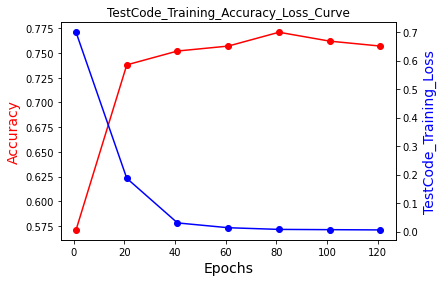

In [27]:
from matplotlib import pyplot as plt

def accuracy_loss_curve(epochs, accuracy, loss, title):
    fig,ax = plt.subplots()
    # make a plot
    ax.plot(epochs, accuracy,  color="red", marker="o")
    # set x-axis label
    ax.set_xlabel("Epochs",fontsize=14)
    # set y-axis label
    ax.set_ylabel("Accuracy",color="red",fontsize=14)
    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(epochs, loss,color="blue",marker="o")
    ax2.set_ylabel(title+"_Loss",color="blue",fontsize=14)
    plt.title(title+"_Accuracy_Loss_Curve")
    plt.show()
    
    
###Test Code, need to remove after integration
epochs=[1,21,41,61,81,101,121]
accuracy=[0.571, 0.738, 0.752, 0.757, 0.771, 0.762, 0.757]
loss=[0.699269, 0.186826, 0.030319, 0.013461, 0.007564, 0.006636, 0.005767]
accuracy_loss_curve(epochs, accuracy, loss, "TestCode_Training")

## DenseNet169 Accuracy_Loss_Curve

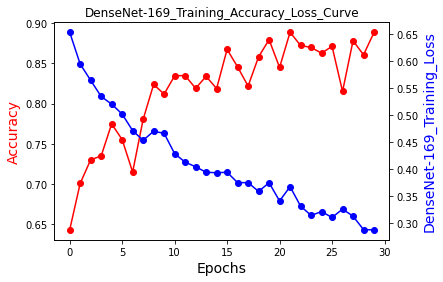

In [28]:
if len(denseNetAccuracy)==0:
    denseNetAccuracy=[0]*len(denseNetEpochs)
#denseNetEpochs=10    
accuracy_loss_curve(denseNetEpochs,denseNetAccuracy,denseNetLoss,"DenseNet-169_Training")

## Resnet50 Accuracy_Loss_Curve

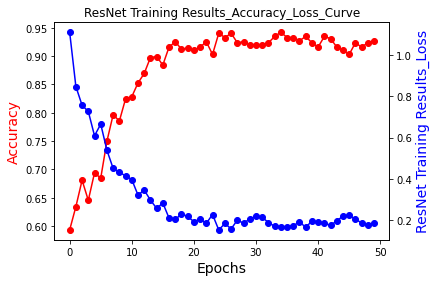

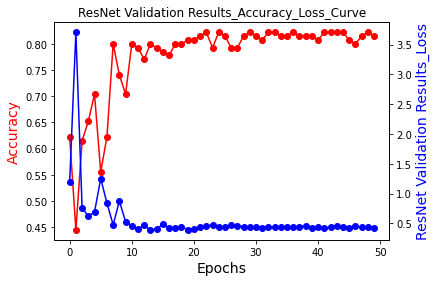

In [29]:
# train loss
accuracy_loss_curve(list(range(50)), resnet_stats["train"]["acc"], resnet_stats["train"]["loss"], "ResNet Training Results")
# val loss
accuracy_loss_curve(list(range(50)), resnet_stats["val"]["acc"], resnet_stats["val"]["loss"], "ResNet Validation Results")

## Chexnet Accuracy_Loss_Curve

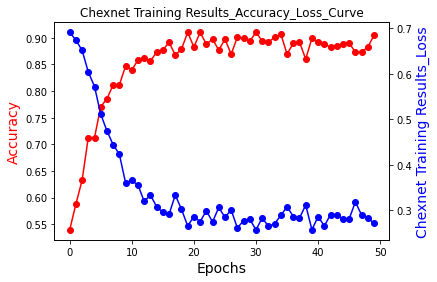

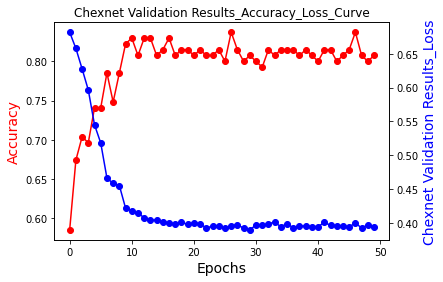

In [30]:
# train loss
accuracy_loss_curve(list(range(50)), chexnet_stats["train"]["acc"], chexnet_stats["train"]["loss"], "Chexnet Training Results")
# val loss
accuracy_loss_curve(list(range(50)), chexnet_stats["val"]["acc"], chexnet_stats["val"]["loss"], "Chexnet Validation Results")

## Model Evaluation

In [31]:
!pip install seaborn

In [32]:
def eval_model(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    
    y_pred = []
    y_true = []
    

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, pred = torch.max(outputs.data, 1)

            y_pred += pred.tolist()
            y_true += labels.tolist()

    return y_pred, y_true

In [33]:
from sklearn.metrics import *
import seaborn as sns

def classification_metrics(Y_pred, Y_true):
    acc, auc, precision, recall, f1score = accuracy_score(Y_true, Y_pred), \
                                           roc_auc_score(Y_true, Y_pred), \
                                           precision_score(Y_true, Y_pred), \
                                           recall_score(Y_true, Y_pred), \
                                           f1_score(Y_true, Y_pred)
    return acc, auc, precision, recall, f1score

def visualize_confusion_matrix(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

def get_confusion_matrix(Y_pred, Y_true):
    #true_pos, false_neg, false_pos, true_neg = confusion_matrix(Y_true, Y_pred)
    cf_matrix=confusion_matrix(Y_true, Y_pred)
    visualize_confusion_matrix(cf_matrix)
    return cf_matrix
    
def eval_metrics(model, loader):
  y_pred, y_true = eval_model(model, loader)
  val_acc, val_roc_auc, val_precision, val_recall, val_f1 = classification_metrics(y_pred, y_true)

  print("Accuracy:", str(val_acc), "\n", "F1 score:", str(val_f1), "\n", "ROC AUC Score:", str(val_roc_auc), "\n")

  cf_matrix = get_confusion_matrix(y_pred, y_true)
  visualize_confusion_matrix(cf_matrix)



## Model Evaluation DenseNet169



In [34]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

y_pred, y_true = eval_model(densenet169_extended, val_loader)
val_acc, val_roc_auc, val_precision, val_recall, val_f1 = classification_metrics(y_pred, y_true)
print("Validation data metrics", "\n", "Accuracy:", str(val_acc), "\n", "F1 score:", str(val_f1), "\n", "ROC AUC Score:", str(val_roc_auc), "\n")

y_pred, y_true = eval_model(densenet169_extended, test_loader)
test_acc, test_roc_auc, test_precision, test_recall, test_f1 = classification_metrics(y_pred, y_true)

print("Test data metrics", "\n", "Accuracy:", str(test_acc), "\n", "F1 score:", str(test_f1), "\n", "ROC AUC Score:", str(test_roc_auc), "\n")


Validation data metrics 
 Accuracy: 0.8 
 F1 score: 0.7938931297709924 
 ROC AUC Score: 0.809099018733274 

Test data metrics 
 Accuracy: 0.9066666666666666 
 F1 score: 0.9113924050632912 
 ROC AUC Score: 0.9061166429587482 



## Model Evaluation Resnet50


ResNet Test Data Metrics
Accuracy: 0.9066666666666666 
 F1 score: 0.9113924050632912 
 ROC AUC Score: 0.9061166429587482 



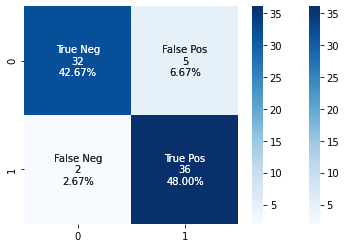

In [35]:
print("ResNet Test Data Metrics")
eval_metrics(resnet_model, test_loader)


## Model Evaluation Chexnet


Chexnet data metrics
Accuracy: 0.8666666666666667 
 F1 score: 0.8571428571428572 
 ROC AUC Score: 0.8677098150782362 



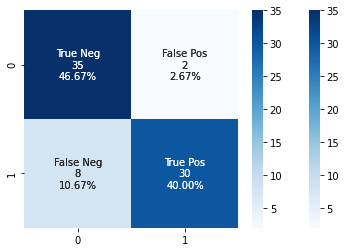

In [36]:
print("Chexnet data metrics")
eval_metrics(chexnet_model, test_loader)

#DenseNet Confusion Matrix

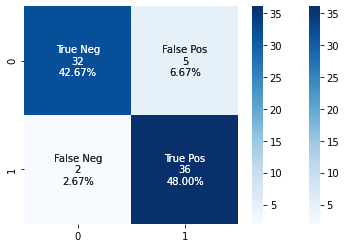

In [37]:
#y_pred, y_true = eval_model(densenet169_extended, test_loader)
cf_matrix = get_confusion_matrix(y_pred, y_true)
visualize_confusion_matrix(cf_matrix)